In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
#tf.enable_eager_execution()

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import numpy as np

import tensorflow.keras

import os
from glob import glob

import timeit

from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import clear_output
import datetime

import pandas as pd

In [2]:
tf.reset_default_graph()

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
from Model import make_KaI

In [5]:
img_height = 1000
img_width = 1000
nclasses=2
filters=16
one_hot=2
deep = True
zero_pad = 0

KaI = make_KaI(img_height, img_width, nclasses, filters, one_hot, deep, zero_pad, channels = 1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
from keras.utils.layer_utils import count_params

trainable_count = count_params(KaI.trainable_weights)
non_trainable_count = count_params(KaI.non_trainable_weights)
print(trainable_count)

536934


Using TensorFlow backend.


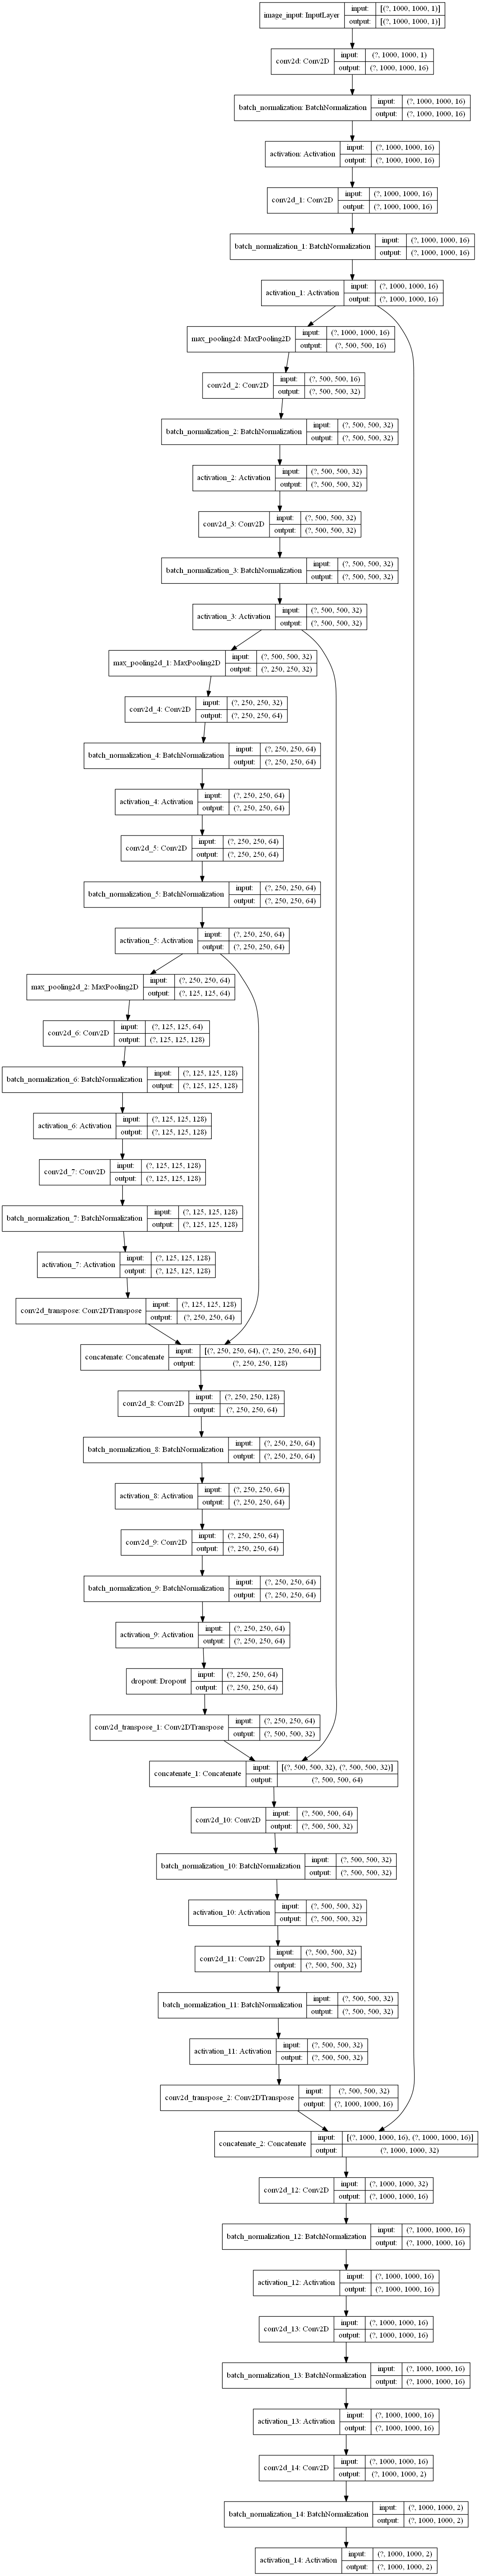

In [6]:
import pydotplus
import keras.utils
keras.utils.vis_utils.pydot = pydotplus
tf.keras.utils.plot_model(KaI, to_file="D:/Masterarbeit/Data/model_full_KaI_slovenia_not_one_hot.png", show_shapes=True)

In [7]:
from Data import image_generator

In [8]:
files_mask_train = glob("D:\\Masterarbeit\\Data\\high_res\\slovenia_1m\\tf_data\\train\\WOKAM\\subfolder\\*")
files_img_train = glob("D:\\Masterarbeit\\Data\\high_res\\slovenia_1m\\tf_data\\train\\LIDAR\\subfolder\\*")

files_mask_test = glob("D:\\Masterarbeit\\Data\\high_res\\slovenia_1m\\tf_data\\test\\WOKAM\\subfolder\\*")
files_img_test = glob("D:\\Masterarbeit\\Data\\high_res\\slovenia_1m\\tf_data\\test\\LIDAR\\subfolder\\*")

In [9]:
train_generator = image_generator(files_img_train, files_mask_train, batch_size = 2, intensify = False, random = True, categorical =True, lidar = True)
test_generator = image_generator(files_img_test, files_mask_test, batch_size = 2, intensify = False, random = False, categorical = True, lidar = True)

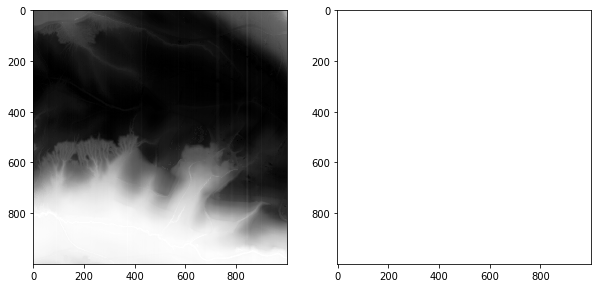

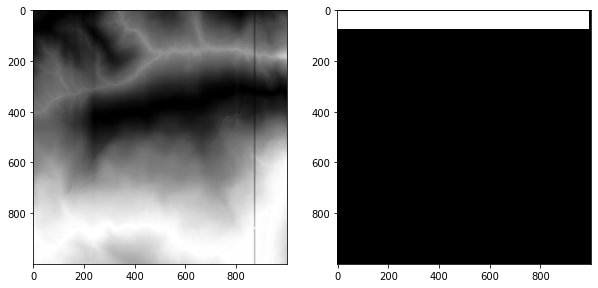

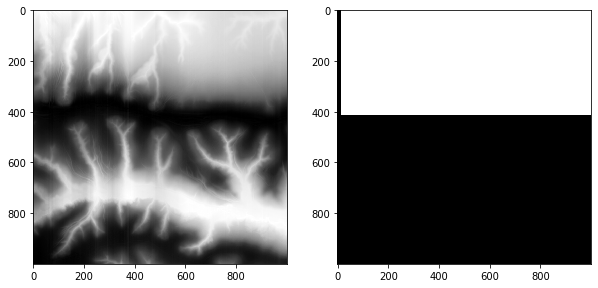

In [14]:
for i in range(0,3):
    
    x, y = next(train_generator)
    
    image = x[i].reshape(1000,1000)
    #mask = np.argmax(y[i], axis=2)
    mask = y[i].reshape(1000,1000)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
    ax1.imshow(image, cmap = "Greys")
    ax2.imshow(mask, cmap = "Greys")
    
    plt.show()

In [10]:
adam = tf.keras.optimizers.Adam(lr=0.001)

In [11]:
KaI.compile(optimizer= adam, loss = "categorical_crossentropy", metrics=['categorical_accuracy'])

In [11]:
import keras.backend as K
def dice_coef_9cat(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 2 categories.
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.cast(y_true, 'float32')[...,0:])
    y_pred_f = K.flatten(y_pred[...,0:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_coef_9cat_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_9cat(y_true, y_pred)

In [12]:
KaI.compile(optimizer= adam, loss = dice_coef_9cat_loss, metrics=['categorical_accuracy'])

In [13]:
batch_size = 2

In [15]:
tb_dir = "D:\\Masterarbeit\\Data\\logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+ "_high_res_custom_loss"

tb = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, write_graph=True, histogram_freq= 1)
mc = tf.keras.callbacks.ModelCheckpoint(mode='max', filepath='D:/Masterarbeit/Data/weights/top_weights_200511_high_res_custom_loss.h5', monitor='categorical_accuracy', save_best_only='True', save_weights_only='True', verbose=1)
callbacks = [tb, mc]

a = datetime.datetime.now()
history = KaI.fit_generator(
train_generator,
steps_per_epoch=len(files_mask_train) // batch_size,
epochs= 50,
validation_data= test_generator,
validation_steps=len(files_mask_test) // batch_size , 
callbacks=callbacks
)
b = datetime.datetime.now()
print(b-a)

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'D:/Masterarbeit/Data/weights/history_high_res_custom_loss.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

Epoch 1/50
20/86 [=====>........................] - ETA: 13:29 - loss: 0.4926 - categorical_accuracy: 0.4557
Epoch 00001: categorical_accuracy improved from -inf to 0.63299, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_high_res_custom_loss.h5
86/86 [==============================] - 1338s 16s/step - loss: 0.4419 - categorical_accuracy: 0.6330 - val_loss: 0.4926 - val_categorical_accuracy: 0.4557
Epoch 2/50
20/86 [=====>........................] - ETA: 13:31 - loss: 0.5079 - categorical_accuracy: 0.4333
Epoch 00002: categorical_accuracy did not improve from 0.63299
86/86 [==============================] - 1309s 15s/step - loss: 0.4329 - categorical_accuracy: 0.6264 - val_loss: 0.5079 - val_categorical_accuracy: 0.4333
Epoch 3/50
20/86 [=====>........................] - ETA: 13:55 - loss: 0.4759 - categorical_accuracy: 0.4608
Epoch 00003: categorical_accuracy improved from 0.63299 to 0.66506, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_high_res_cust

Epoch 19/50
20/86 [=====>........................] - ETA: 12:33 - loss: 0.2283 - categorical_accuracy: 0.9187
Epoch 00019: categorical_accuracy did not improve from 0.74684
86/86 [==============================] - 1284s 15s/step - loss: 0.3277 - categorical_accuracy: 0.7264 - val_loss: 0.2283 - val_categorical_accuracy: 0.9187
Epoch 20/50
20/86 [=====>........................] - ETA: 12:38 - loss: 0.2277 - categorical_accuracy: 0.9142
Epoch 00020: categorical_accuracy did not improve from 0.74684
86/86 [==============================] - 1289s 15s/step - loss: 0.3314 - categorical_accuracy: 0.7222 - val_loss: 0.2277 - val_categorical_accuracy: 0.9142
Epoch 21/50
20/86 [=====>........................] - ETA: 12:43 - loss: 0.2152 - categorical_accuracy: 0.9163
Epoch 00021: categorical_accuracy did not improve from 0.74684
86/86 [==============================] - 1291s 15s/step - loss: 0.3355 - categorical_accuracy: 0.7055 - val_loss: 0.2152 - val_categorical_accuracy: 0.9163
Epoch 22/50
2

In [15]:
tb_dir = "D:\\Masterarbeit\\Data\\logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+ "_high_res_categorical"

tb = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, write_graph=True, histogram_freq= 1)
mc = tf.keras.callbacks.ModelCheckpoint(mode='max', filepath='D:/Masterarbeit/Data/weights/top_weights_200511_high_categorical.h5', monitor='categoricalc uracy', save_best_only='True', save_weights_only='True', verbose=1)
callbacks = [tb, mc]

a = datetime.datetime.now()
history = KaI.fit_generator(
train_generator,
steps_per_epoch=len(files_mask_train) // batch_size,
epochs= 100,
validation_data= test_generator,
validation_steps=len(files_mask_test) // batch_size , 
callbacks=callbacks
)
b = datetime.datetime.now()
print(b-a)

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'D:/Masterarbeit/Data/weights/history_high_res_categorical.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

Epoch 1/100
20/86 [=====>........................] - ETA: 13:38 - loss: 0.6022 - categorical_accuracy: 0.8443
Epoch 00001: categorical_accuracy improved from -inf to 0.64357, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_high_categorical.h5
86/86 [==============================] - 1234s 14s/step - loss: 0.6632 - categorical_accuracy: 0.6436 - val_loss: 0.6022 - val_categorical_accuracy: 0.8443
Epoch 2/100
20/86 [=====>........................] - ETA: 14:03 - loss: 0.6116 - categorical_accuracy: 0.8118
Epoch 00002: categorical_accuracy improved from 0.64357 to 0.72313, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_high_categorical.h5
86/86 [==============================] - 1276s 15s/step - loss: 0.6229 - categorical_accuracy: 0.7231 - val_loss: 0.6116 - val_categorical_accuracy: 0.8118
Epoch 3/100
20/86 [=====>........................] - ETA: 14:29 - loss: 0.5118 - categorical_accuracy: 0.9695
Epoch 00003: categorical_accuracy did not improve from 0.

Epoch 19/100
20/86 [=====>........................] - ETA: 12:05 - loss: 0.3962 - categorical_accuracy: 0.9695
Epoch 00019: categorical_accuracy did not improve from 0.76520
86/86 [==============================] - 1158s 13s/step - loss: 0.5588 - categorical_accuracy: 0.7379 - val_loss: 0.3962 - val_categorical_accuracy: 0.9695
Epoch 20/100
20/86 [=====>........................] - ETA: 11:54 - loss: 0.3884 - categorical_accuracy: 0.9695
Epoch 00020: categorical_accuracy improved from 0.76520 to 0.77768, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_high_categorical.h5
86/86 [==============================] - 1155s 13s/step - loss: 0.5409 - categorical_accuracy: 0.7777 - val_loss: 0.3884 - val_categorical_accuracy: 0.9695
Epoch 21/100
20/86 [=====>........................] - ETA: 11:54 - loss: 0.3779 - categorical_accuracy: 0.9594
Epoch 00021: categorical_accuracy improved from 0.77768 to 0.79165, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_high_cat

Epoch 56/100
20/86 [=====>........................] - ETA: 11:48 - loss: 0.3183 - categorical_accuracy: 0.9610
Epoch 00056: categorical_accuracy improved from 0.80577 to 0.80988, saving model to D:/Masterarbeit/Data/weights/top_weights_200511_high_categorical.h5
86/86 [==============================] - 1152s 13s/step - loss: 0.4940 - categorical_accuracy: 0.8099 - val_loss: 0.3183 - val_categorical_accuracy: 0.9610
Epoch 57/100
20/86 [=====>........................] - ETA: 11:54 - loss: 0.3249 - categorical_accuracy: 0.9677
Epoch 00057: categorical_accuracy did not improve from 0.80988
86/86 [==============================] - 1153s 13s/step - loss: 0.6098 - categorical_accuracy: 0.7083 - val_loss: 0.3249 - val_categorical_accuracy: 0.9677
Epoch 58/100
20/86 [=====>........................] - ETA: 11:45 - loss: 0.3270 - categorical_accuracy: 0.9639
Epoch 00058: categorical_accuracy did not improve from 0.80988
86/86 [==============================] - 1149s 13s/step - loss: 0.5339 - cate

Epoch 75/100
20/86 [=====>........................] - ETA: 14:13 - loss: 0.3277 - categorical_accuracy: 0.9634
Epoch 00075: categorical_accuracy did not improve from 0.80988
86/86 [==============================] - 1258s 15s/step - loss: 0.6016 - categorical_accuracy: 0.7099 - val_loss: 0.3277 - val_categorical_accuracy: 0.9634
Epoch 76/100
20/86 [=====>........................] - ETA: 14:11 - loss: 0.3424 - categorical_accuracy: 0.9580
Epoch 00076: categorical_accuracy did not improve from 0.80988
86/86 [==============================] - 1279s 15s/step - loss: 0.5215 - categorical_accuracy: 0.7762 - val_loss: 0.3424 - val_categorical_accuracy: 0.9580
Epoch 77/100
20/86 [=====>........................] - ETA: 13:57 - loss: 0.3297 - categorical_accuracy: 0.9615
Epoch 00077: categorical_accuracy did not improve from 0.80988
86/86 [==============================] - 1278s 15s/step - loss: 0.6107 - categorical_accuracy: 0.7083 - val_loss: 0.3297 - val_categorical_accuracy: 0.9615
Epoch 78/1

Epoch 94/100
20/86 [=====>........................] - ETA: 11:53 - loss: 0.3133 - categorical_accuracy: 0.9587
Epoch 00094: categorical_accuracy did not improve from 0.80988
86/86 [==============================] - 1154s 13s/step - loss: 0.5158 - categorical_accuracy: 0.7812 - val_loss: 0.3133 - val_categorical_accuracy: 0.9587
Epoch 95/100
20/86 [=====>........................] - ETA: 11:47 - loss: 0.3025 - categorical_accuracy: 0.9656
Epoch 00095: categorical_accuracy did not improve from 0.80988
86/86 [==============================] - 1150s 13s/step - loss: 0.5730 - categorical_accuracy: 0.7377 - val_loss: 0.3025 - val_categorical_accuracy: 0.9656
Epoch 96/100
20/86 [=====>........................] - ETA: 11:43 - loss: 0.3082 - categorical_accuracy: 0.9695
Epoch 00096: categorical_accuracy did not improve from 0.80988
86/86 [==============================] - 1149s 13s/step - loss: 0.5742 - categorical_accuracy: 0.7296 - val_loss: 0.3082 - val_categorical_accuracy: 0.9695
Epoch 97/1